## Setup

### Model Class

Define a class that can describe the right-hand side of a DDE, 
$$x'(t) = F(x(t), y(t), t) $$

In our case, the right-hand side we want to learn will be
1. $F(x, y, t) = x(1 - y) $
2. $F(x, y, t) = \sin{x}$

The `Model` class defines an object that can act like the function $F$.

### DDE Solver

This is an algorithm to solve a DDE of the following form:
$$\begin{aligned} x'(t) &= F(x(t), x(t - \tau), t) \qquad t \in [0, T] \\
x(t) &= x_0 \qquad \qquad \qquad \qquad \quad  t \in [-\tau, 0] \end{aligned}$$

We find an approximate solution using a forward euler solver for DDEs.

### NDDE class

Here we define the `NDDE_1D` class. This class acts as a wrapper around a `Model` object. Recall that a `Model` object acts like the function $F$ in the following DDE:
$$\begin{aligned} x'(t) &= F(x(t), x(t - \tau), \tau, t) \qquad t \in [0, T] \\
x(t) &= x_0 \qquad \qquad \qquad \qquad \qquad  t \in [-\tau, 0] \end{aligned}$$
The `NDDE_1D` class accepts a `Model`. Its forward method solves the implied DDE on the interval $[0, T]$ and then returns the result.

### Loss

Here, we implement the loss functions that we try to minimize. 

In [4]:
# Python Libraries
import  os;
from    typing              import      List, Dict, Tuple;

# External libraries. 
import  numpy;
import  matplotlib.pyplot       as      plt;
import  matplotlib              as      mpl;
import  seaborn;
import  torch;
from    torch.utils.tensorboard import  SummaryWriter;
from    scipy                   import  interpolate;

# My code
from    Solver  import  RK2                 as DDE_Solver;
from    NDDE    import  NDDE;
from    Train   import  Train;
from    Utils   import  Initialize_Logger, Initialize_MPL;
from    Loss    import  L1_Cost, L2_Cost, Integral_Loss;

# Set up the TensorBoard SummaryWriter
Base_Dir    : str   = "./Logs";
Counter     : int   = 0;
Log_Dir     : str   = os.path.join(Base_Dir, "Version_" + str(Counter));
while(os.path.isdir(Log_Dir) == True):
    Counter += 1;
    Log_Dir  = os.path.join(Base_Dir, "Version_" + str(Counter));
TB_Writer = SummaryWriter(log_dir = Log_Dir);

# Set up the logger setup.
import  logging;
Initialize_Logger(level = logging.INFO);
LOGGER : logging.Logger = logging.getLogger(__name__);

# Set up cost functions.
l = L2_Cost(Weight = torch.tensor([0.5, 1.0, 1.0]));
G = L2_Cost(Weight = 0.1);

# Set up plotting. 
Initialize_MPL();

### Generate Target Trajectory

Generate the target trajectory and plot it!

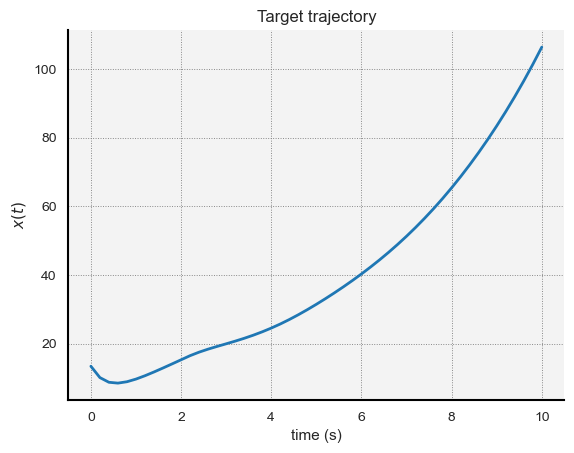

In [5]:
"""
from    Model   import  Cheyne              as F_Model;
from    X0      import  Affine              as X0_Model;

# Set up the parameters and tau value for the target trajectory.
F_Target        = F_Model(p = 1.0, V0 = 7.0, a = 2.0, m = 8);
a_Target        = torch.Tensor([0.5]);
b_Target        = torch.Tensor([2]);
X0_Target       = X0_Model(a = a_Target, b = b_Target);
tau_Target      = torch.tensor(0.25);
T_Target        = torch.tensor(3.0);
"""

from    Model   import  HIV                 as F_Model;
from    X0      import  Affine              as X0_Model;

# Set up the parameters and tau value for the target trajectory.
F_Target        = F_Model(  k   = .0343, 
                            T0  = 1800.0, 
                            m   = 2.0, 
                            d   = 0.05, 
                            np  = 0.43, 
                            N   = 48., 
                            c   = 3.0);
a_Target        = torch.Tensor([0, 0,       0]);
b_Target        = torch.Tensor([10, 13.4, 0]);
X0_Target       = X0_Model(a = a_Target, b = b_Target);
tau_Target      = torch.tensor(2.0);
T_Target        = torch.tensor(10.0)


# Get the target trajectory!
x_Target, t_Target  = DDE_Solver(F = F_Target, X0 = X0_Target, tau = tau_Target, T = T_Target);

# Finally, lets plot the target trajectory.
seaborn.lineplot(x = t_Target, y = x_Target[:, 1].reshape(-1).detach().numpy());
seaborn.despine();
plt.xlabel("time (s)");
plt.ylabel(r"$x(t)$");
plt.title("Target trajectory");

### Train the model

In [13]:
"""
# Cheyne

# Pick a starting position, tau, and x0
tau     = (tau_Target + 0.1).clone().detach().requires_grad_(True);
a       = (a_Target + 0.1).clone().detach().requires_grad_(True);
b       = (b_Target - 0.1).clone().detach().requires_grad_(True);
T       = torch.clone(T_Target).requires_grad_(False);

# Set up a NDDE object. We will try to train the enclosed model to match the one we used to generate the above plot.
F_MODEL     = F_Model(p = 2.0, V0 = 10.0, a = 1.8, m = 8);
X0_MODEL    = X0_Model(a, b);
"""

# HIV 

# Pick a starting position, tau, and x0
tau     = (tau_Target*3.0).clone().detach().requires_grad_(True);
a       = (a_Target*1.0).clone().detach().requires_grad_(True);
b       = (b_Target*1.0).clone().detach().requires_grad_(True);
T       = torch.clone(T_Target).requires_grad_(False);

# Set up a NDDE object. We will try to train the enclosed model to match the one we used to generate the above plot.
F_MODEL     = F_Model(  k   = .0343,#     * 1.1, 
                        T0  = 1800.0,#    * 0.9, 
                        m   = 2.0,#       + 0.3, 
                        d   = 0.05,#      * 1.1, 
                        np  = 0.43,#      + 0.05, 
                        N   = 48.0,#      - 5.0, 
                        c   = 3.0)#       * 0.9);
X0_MODEL    = X0_Model(a, b);

# Settings for training
N_Epochs        : int       = 1000;
Learning_Rate   : float     = 0.01;
Loss_Threshold  : float     = 0.01;             # Will exit when loss drops below this.

# Set up the DDE Module
DDE_Module  = NDDE(F = F_MODEL, X0 = X0_MODEL);


# Select the optimizer, number of epochs.
Param_List  : List  = [tau] #+ list(X0_MODEL.parameters()) + list(F_MODEL.parameters());
Optimizer           = torch.optim.Adam(Param_List, lr = Learning_Rate);
Scheduler           = torch.optim.lr_scheduler.CosineAnnealingLR(
                                            optimizer   = Optimizer, 
                                            T_max       = N_Epochs, 
                                            eta_min     = Learning_Rate/5.);

# Train!
t_Predict, x_Predict  = Train(  DDE_Module      = DDE_Module, 
                                tau             = tau, 
                                T               = T, 
                                N_Epochs        = N_Epochs, 
                                x_Target        = x_Target, 
                                t_Target        = t_Target, 
                                l               = l,
                                G               = G,
                                Loss_Threshold  = Loss_Threshold, 
                                Optimizer       = Optimizer, 
                                Scheduler       = Scheduler,
                                Writer          = TB_Writer);

  10:   Loss = 7840.57812  | tau = 5.89954  | grad tau = 102.89844
  20:   Loss = 7831.56836  | tau = 5.79670  | grad tau = 119.89093
  30:   Loss = 7826.65967  | tau = 5.68927  | grad tau = 155.77515
  40:   Loss = 7821.05664  | tau = 5.57315  | grad tau = 186.19199
  50:   Loss = 7812.43213  | tau = 5.44937  | grad tau = 223.82547
  60:   Loss = 7805.33057  | tau = 5.31685  | grad tau = 298.71307
  70:   Loss = 7796.92285  | tau = 5.17350  | grad tau = 370.20749
  80:   Loss = 7787.50977  | tau = 5.02025  | grad tau = 506.46347
  90:   Loss = 7777.53418  | tau = 4.85572  | grad tau = 696.13983
 100:   Loss = 7766.12744  | tau = 4.67952  | grad tau = 909.31506
 110:   Loss = 7751.85107  | tau = 4.49235  | grad tau = 1290.09521
 120:   Loss = 7732.60547  | tau = 4.29425  | grad tau = 1856.05786
 130:   Loss = 7705.20215  | tau = 4.08545  | grad tau = 2708.25708
 140:   Loss = 7664.60156  | tau = 3.86673  | grad tau = 4232.44678
 150:   Loss = 7605.59570  | tau = 3.63835  | grad tau = 6

### Plot the Predicted vs Target trajectories

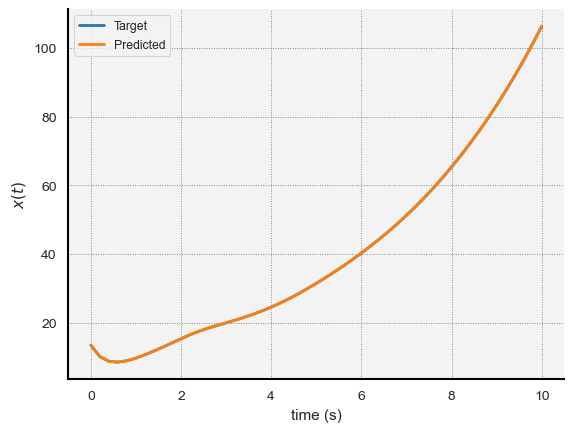

In [14]:
####################################################################################################
# Plot target, final trajectory

plt.figure(1);
plt.plot(t_Target,  x_Target[:,  1].detach().numpy(),   label = "true");
plt.plot(t_Predict, x_Predict[:, 1].detach().numpy(),  label = "discovered");
seaborn.despine();
plt.xlabel("time (s)");
plt.ylabel(r"$x(t)$");
plt.legend(["Target","Predicted"]);

### Plot the loss as a function of $\tau$

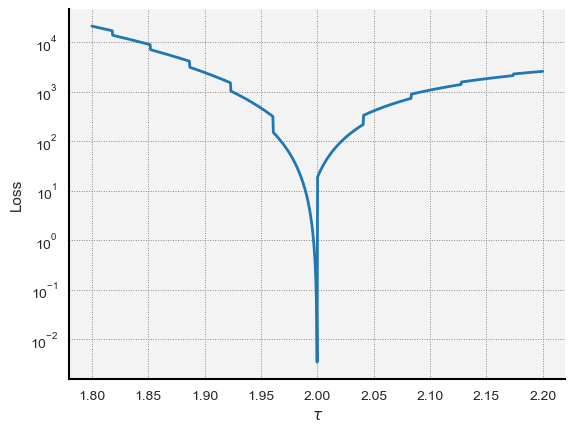

In [15]:
####################################################################################################
# Plot loss as a function of tau


# Build initial model
Model = F_Target;

# Set up a grid of tau values. We will find the loss at each one.
N_Steps : int   = 1000;
grid_tau        = torch.linspace(1.8, 2.2, steps = N_Steps, requires_grad = True);
Loss_tau        = torch.zeros(N_Steps);

for i in range(N_Steps):
    # Find predictions for ith tau value.
    Predictions_i : torch.Tensor = DDE_Solver(Model, X0_Target, grid_tau[i], T)[0];

    # Interpolate true solution on the time step grid for this solution.
    N_i                 : int           = Predictions_i.shape[0];
    x_Interp                            = interpolate.CubicSpline(t_Target.detach().numpy(), x_Target.detach().numpy());
    t_Values            : numpy.ndarray = numpy.linspace(start = 0, stop = T.item(), num = N_i);
    Targets_i           : torch.Tensor  = torch.from_numpy(x_Interp(t_Values)).to(dtype = torch.float32);
    
    # Compute loss
    Loss_tau[i] = Integral_Loss(Predictions_i, Targets_i, t_Values, l) + G(Targets_i[-1, :], Predictions_i[-1, :]);

# Plot!
plt.figure(2);
seaborn.lineplot(x = grid_tau.detach().numpy(), y = Loss_tau.detach().numpy());
seaborn.despine();
plt.xlabel(r"$\tau$");
plt.ylabel("Loss");
plt.yscale("log");

### Serialize the model

In [36]:
# First, find a save name
Base_Name   : str   = "Neural";
Save_Dir    : str   = os.path.join(os.curdir, "Saves");
Counter     : int   = 0;

Save_Path   : str   = os.path.join(Save_Dir, Base_Name + "_" + str(Counter));
while(os.path.isfile(Save_Path)):
    Counter    += 1;
    Save_Path   = os.path.join(Save_Dir, Base_Name + "_" + str(Counter));

# Now, serialize the model. 
F_State_Dict    : dict  = F_MODEL.state_dict();
X0_State_Dict   : dict  = X0_MODEL.state_dict();
Save_Dict       : dict  = {"F" : F_State_Dict, "Widths" : Widths, "X0" : X0_State_Dict, "tau" : tau};
torch.save(Save_Dict, Save_Path);